Import relevant libraries

In [1]:
import pandas as pd
import numpy as np
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from transformers import AutoModelForTokenClassification, AutoTokenizer, pipeline, AutoModelForSequenceClassification
import torch
import gensim
from gensim import corpora
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pycountry
from geopy.geocoders import Nominatim
import time
import re
from nltk.stem import PorterStemmer


In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUSROG\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUSROG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Load the dataset

In [6]:
# Load the dataset
df = pd.read_csv(r"C:\Users\ASUSROG\Downloads\news_excerpts_parsed.csv")

df = df['Text']
df.head()

0    Starbucks violated federal labor law when it i...
1    The first suspect to plead guilty in Singapore...
2    Meta has been fined a record-breaking €1.2 bil...
3    SINGAPORE: A 45-year-old man linked to Singapo...
4    The Department of Education imposed a record $...
Name: Text, dtype: object

Remove any empty rows

In [7]:
texts = df.dropna().tolist()

In [8]:
print(texts[:2])

['Starbucks violated federal labor law when it increased wages and offered new perks and benefits only to non-union employees, a National Labor Relations Board judge found Thursday.\n\nThe decision is the latest in a series of NLRB rulings finding that Starbucks has violated labor law in its efforts to stop unions from forming in its coffee shops.\n\n“The issue at the heart of this case is whether, under current Board law, [Starbucks] was entitled to explicitly reward employees,” for not participating in union activity, “while falsely telling its workers that the federal labor law forced it to take this action,” wrote administrative law judge Mara-Louise Anzalone. “It was not.”', "The first suspect to plead guilty in Singapore's largest money laundering case was convicted and sentenced to 13 months' jail in a district court on Tuesday (Apr 2).\n\nSu Wenqiang, 32, admitted to 11 charges of money laundering, possessing proceeds from illegal remote gambling offences and lying to get work 

Throughout the code, to minimise scrolling, we will only be using subsets of the dataset

Basic Named-Entity Recognition (NER) using Spacy and Visualisation using NetworkX

In [9]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Extract named entities
entities = []
for text in texts:
    doc = nlp(text)
    for ent in doc.ents:
        entities.append((ent.text, ent.label_))

# Convert to DataFrame for analysis
entities_df = pd.DataFrame(entities, columns=["Entity", "Type"])
print(entities_df.head())


                           Entity  Type
0  National Labor Relations Board   ORG
1                        Thursday  DATE
2                            NLRB   ORG
3                       Starbucks   ORG
4                           Board   ORG


     Entity1 Relation            Entity2
0   violated    nsubj          Starbucks
1   violated     dobj  federal labor law
2  increased    nsubj                 it
3  increased     dobj              wages
4    offered     dobj          new perks


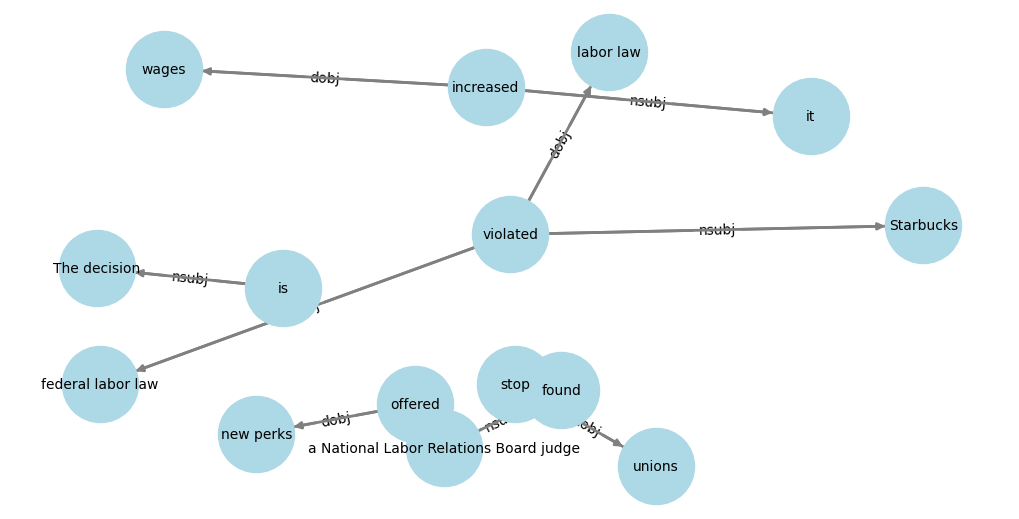

In [10]:
def get_noun_phrases(doc):
    noun_phrases = {chunk.root: chunk.text for chunk in doc.noun_chunks}  # Mapping root words to full phrases
    return noun_phrases

# Function to merge proper nouns joined by "and"
def merge_proper_nouns(doc):
    tokens = list(doc)
    merged_tokens = []
    i = 0

    while i < len(tokens):
        token = tokens[i]

        # If the token is a proper noun and followed by "and" + another proper noun
        if token.pos_ == "PROPN" and i + 2 < len(tokens) and tokens[i + 1].text.lower() == "and" and tokens[i + 2].pos_ == "PROPN":
            merged_entity = f"{token.text} and {tokens[i + 2].text}"
            merged_tokens.append(merged_entity)
            i += 3  # Skip the next two tokens ("and" and the second proper noun)
        else:
            merged_tokens.append(token.text)
            i += 1

    return merged_tokens

# List to store extracted relationships
relations = []

# Process each text
for text in texts:
    doc = nlp(text)

    # Get noun phrases (e.g., "federal law" instead of just "law")
    noun_phrases = get_noun_phrases(doc)

    # Merge proper nouns with "and"
    merged_tokens = merge_proper_nouns(doc)

    for token in doc:
        # Identify subject-object pairs (Who did what to whom?)
        if token.dep_ in ("nsubj", "dobj"):  # Subject-Object dependency
            head = token.head.text  # The main verb (action word)
            entity = noun_phrases.get(token, token.text)  # Use full noun phrase if available

            # Replace entity if it appears in the merged list
            if entity in merged_tokens:
                entity = merged_tokens[merged_tokens.index(entity)]

            relation = token.dep_  # Relationship type (nsubj/dobj)
            relations.append((head, relation, entity))

# Convert extracted relationships to a DataFrame
relations_df = pd.DataFrame(relations, columns=["Entity1", "Relation", "Entity2"])

# Display results
print(relations_df.head())

# Create a directed graph
G = nx.DiGraph()

relations = relations[:10]

# Add edges for each relationship
for entity1, relation, entity2 in relations:
    G.add_edge(entity1, entity2, label=relation)

# Draw the graph
plt.figure(figsize=(10, 5))
pos = nx.spring_layout(G, k=0.5, seed=42)  # Position nodes using a layout
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=3000, font_size=10, width=2)

# Add labels to edges
edge_labels = {(e1, e2): rel for e1, rel, e2 in relations}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Increase arrow size for visibility
nx.draw_networkx_edges(G, pos, width=2, edge_color="gray", arrowsize=20)

plt.show()

Relations Dataframe

In [11]:
relations_df[:20]

,Entity1,Relation,Entity2
0,violated,nsubj,Starbucks
1,violated,dobj,federal labor law
2,increased,nsubj,it
3,increased,dobj,wages
4,offered,dobj,new perks
5,found,nsubj,a National Labor Relations Board judge
6,is,nsubj,The decision
7,violated,nsubj,Starbucks
8,violated,dobj,labor law
9,stop,dobj,unions


More comprehensive NER using Hugging Face pre-trained BERT model fine-tuned on the CoNLL-03 dataset

In [12]:
# Load Hugging Face model for NER
model_name = "dbmdz/bert-large-cased-finetuned-conll03-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# Load NER pipeline
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer)

text123 = texts[:20]

# Extract named entities
for text in texts:
    ner_results = ner_pipeline(text)
    print(f"\nText: {text}")
    for entity in ner_results:
        print(f"{entity['word']} - {entity['entity']} (Score: {entity['score']:.2f})")
    break

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu



Text: Starbucks violated federal labor law when it increased wages and offered new perks and benefits only to non-union employees, a National Labor Relations Board judge found Thursday.

The decision is the latest in a series of NLRB rulings finding that Starbucks has violated labor law in its efforts to stop unions from forming in its coffee shops.

“The issue at the heart of this case is whether, under current Board law, [Starbucks] was entitled to explicitly reward employees,” for not participating in union activity, “while falsely telling its workers that the federal labor law forced it to take this action,” wrote administrative law judge Mara-Louise Anzalone. “It was not.”
Star - I-ORG (Score: 1.00)
##bu - I-ORG (Score: 1.00)
##cks - I-ORG (Score: 1.00)
National - I-ORG (Score: 1.00)
Labor - I-ORG (Score: 1.00)
Relations - I-ORG (Score: 1.00)
Board - I-ORG (Score: 1.00)
NL - I-ORG (Score: 0.99)
##RB - I-ORG (Score: 1.00)
Star - I-ORG (Score: 1.00)
##bu - I-ORG (Score: 1.00)
##cks

This extracts countries from the list of Entities extracted; if there are no country names present, it calculates an average vector for all Entity words and parses spaCy dictionary for the closest word 

In [13]:
# Load Hugging Face model for NER
model_name = "dbmdz/bert-large-cased-finetuned-conll03-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# Load NER pipeline
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

# Load spaCy model with word vectors
nlp = spacy.load("en_core_web_md")  # Ensure model is installed

# Load country list from pycountry
country_list = {country.name.lower() for country in pycountry.countries}

# Step 1: Extract Named Entities (Removing Subword Tokens)
all_entities = []
for text in text123:
    ner_results = ner_pipeline(text)
    
    # Remove entities containing "#" (subword tokens)
    entities = list(set(entity["word"].lower() for entity in ner_results if "#" not in entity["word"]))
    
    all_entities.append(entities)

print("\nExtracted Entities (After Removing Hashes):")
for i, entities in enumerate(all_entities):
    print(f"Text {i+1}: {entities}")

# Step 2: Identify Country Names If Available, Otherwise Use Word Embedding Method
summary_words = []

for i, entities in enumerate(all_entities):
    if not entities:
        summary_words.append("No Entities")  # Handle empty cases
        continue

    # Use spaCy to detect geopolitical entities (GPE) in the text
    doc = nlp(texts[i])
    detected_countries = {ent.text.lower() for ent in doc.ents if ent.label_ == "GPE"}

    # Cross-check with pycountry list
    country_matches = detected_countries.intersection(country_list)

    if country_matches:
        # If multiple countries are found, join them with commas
        summary_words.append(", ".join(sorted(country_matches)))  # Sorted for consistency
        continue

    # If no country is found, use word embedding similarity
    if len(entities) == 1:
        summary_words.append(entities[0])  # If only one entity, return it directly
        continue

    # Compute the average vector of all entity words
    entity_vectors = [nlp(entity).vector for entity in entities if nlp(entity).has_vector]

    if not entity_vectors:  # If no valid word vectors exist
        summary_words.append(entities[0])  # Fallback to first entity
        continue

    centroid_vector = np.mean(entity_vectors, axis=0)  # Compute average vector

    # Find the closest real word in spaCy's vocabulary
    closest_word = max(
    [word for word in nlp.vocab if word.is_alpha],  # Only consider alphabetic words
    key=lambda word: word.vector_norm and np.dot(word.vector, centroid_vector)
)


    summary_words.append(closest_word.text)

# Step 3: Display Results
print("\nFinal Topic Per Text (Multiple Countries Included If Found):")
for i, summary in enumerate(summary_words):
    print(f"Text {i+1}: {summary}")


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu



Extracted Entities (After Removing Hashes):
Text 1: ['starbucks', 'mara - louise anzalone', 'board', 'national labor relations board', 'nlrb']
Text 2: ['fujian', 'su wenqiang', 'su', 'cambodian', 'class b', 's', 'us', 'lewis road', 'bukit timah', 'singapore']
Text 3: ['gdpr', 'united states', 'europe', 'eu', 'general data protection regulation', 'irish data protection commission', 'european data protection board', 'facebook', 'meta', 'fb', 'european union']
Text 4: ['s', 'zhang', 'zhang ruijin', 'singapore']
Text 5: ['christian', 'liberty university', 'virginia', 'department of education', 'clery act']
Text 6: ['oebag', 'kurz', 'vienna', "austrian people ' s party", 'sebastian kurz', 'austrian']
Text 7: ['cac', 'cyberspace administration of china', 'cheng wei', 'english', 'china', 'liu qing', 'jean liu', 'didi global', 'didi']
Text 8: ['alfredo h.', 'albanian', 'brussels criminal court', 'majorca', 'indrit k', 'black eagle', 'italian', 'limburg']
Text 9: ['chamber of deputies', 'feri'

This model extract country names from Entity list, including cities with the help of geopy. Should there by no country names present, it uses LDA on the preprocessed textual data to find a word that is most similar to the text


In [16]:
import re

# Load Hugging Face model for NER
model_name = "dbmdz/bert-large-cased-finetuned-conll03-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# Load NER pipeline
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

# Load spaCy model with word vectors
nlp = spacy.load("en_core_web_md")

# Load country list from pycountry
country_list = {country.name.lower() for country in pycountry.countries}

# Initialize geolocator to map cities to countries
geolocator = Nominatim(user_agent="country_recognition")

# Initialize Porter Stemmer
stemmer = PorterStemmer()

# Load stopwords
stop_words = set(stopwords.words('english'))

# Helper function for text preprocessing
def preprocess_text(text):
    # Remove non-alphabetic characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Convert text to lowercase
    text = text.lower()
    
    return text
#     doc = nlp(text)
#     tokens = [token.text for token in doc]
# #     # Tokenize the text (split into words)
# #     tokens = word_tokenize(text)
    
#     # Remove stopwords and perform stemming
#     tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    
#     # Join tokens back into a string
#     return ' '.join(tokens)

# Step 1: Extract Named Entities (Removing Subword Tokens)
all_entities = []
for text in text123:
    ner_results = ner_pipeline(text)
    
    # Remove entities containing "#" (subword tokens)
    entities = list(set(entity["word"].lower() for entity in ner_results if "#" not in entity["word"]))
    
    all_entities.append(entities)

# Step 2: Normalize and Check Countries
summary_words = []

for i, entities in enumerate(all_entities):
    if not entities:
        summary_words.append("No Entities")  # Handle empty cases
        continue

    # Use spaCy to detect geopolitical entities (GPE) in the text
    doc = nlp(texts[i])
    detected_countries = {ent.text.lower() for ent in doc.ents if ent.label_ == "GPE"}

    # Cross-check with pycountry list
    country_matches = detected_countries.intersection(country_list)

    if country_matches:
        # If multiple countries are found, join them with commas
        summary_words.append(", ".join(sorted(country_matches)))  # Sorted for consistency
        continue

    # If no country is found, attempt to resolve abbreviations or cities
    resolved_countries = []
    for entity in entities:
        if entity == "usa":
            resolved_countries.append("united states")
        else:
            # Attempt to resolve city to country
            location = geolocator.geocode(entity, timeout=10)
            time.sleep(1)
            if location:
                country = location.raw.get("address", {}).get("country", "").lower()
                if country:
                    resolved_countries.append(country)

    if resolved_countries:
        # If resolved countries are found, use them as topics
        summary_words.append(", ".join(sorted(set(resolved_countries))))  # Avoid duplicates
        continue
    
    
    # If no country is found, perform LDA on raw text to extract topic
    cleaned_text = preprocess_text(texts[i])  # Clean text to remove numbers before LDA

    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform([cleaned_text])  # Use cleaned text

    lda = LatentDirichletAllocation(n_components=1, random_state=42)
    lda.fit(X)

    # Get the most important word for the topic (pick the word with the highest weight)
    feature_names = vectorizer.get_feature_names_out()
    topic_word_index = lda.components_.argsort()[:, -1][0]  # Get the word with the highest weight
    topic_word = feature_names[topic_word_index]  # Get the word itself
    
    if topic_word.isdigit():  # If the topic word is a number, skip it
        topic_word = "No Topic Detected"  # You can handle this however you prefer
    
    summary_words.append(topic_word)  # Only the most significant word

# Step 3: Display Results
print("\nFinal Topic Per Text (Including Country Mapping or LDA Topic):")
for i, summary in enumerate(summary_words):
    print(f"Text {i+1}: {summary}")


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu



Final Topic Per Text (Including Country Mapping or LDA Topic):
Text 1: law
Text 2: singapore
Text 3: data
Text 4: singapore
Text 5: education
Text 6: trial
Text 7: china
Text 8: drug
Text 9: feri
Text 10: denmark
Text 11: griners
Text 12: congress
Text 13: estonia
Text 14: finland, sweden
Text 15: reykjavk
Text 16: japan, lebanon
Text 17: china
Text 18: johor
Text 19: labor
Text 20: khaydarshin
